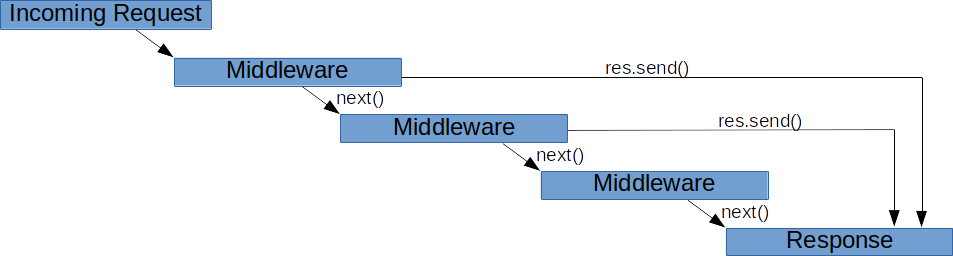

In [ ]:
# Middleware

<!-- Routing cơ bản -->
`app.METHOD(PATH, HANDLER)`
Hàm xử lý handler (Tham số thứ 2) có dạng là:
```js
(req, res) => {
	//todo: Xử lý yêu cầu gửi đến và trả về res cho Client
}
```

---

- Middleware là phần mềm trung gian
- Nếu `.METHOD()`: có tham số thứ 2 là hàm thì nó là middleware
- `app.METHOD(PATH, (req, res) => {}, (req, res) => {}, (req, res) => {})`: `(req, res) => {...}` --> Đây là middleware

- Vai trò của thằng `(req, res) => {}` cuối cùng thông thường là thằng xử lý chính
VD: Routing lấy về danh sách các nhiệm vụ. Thì thằng cuối cùng sẽ đảm nhiệm là trả về response danh sách, mảng đó

- Middleware đứng ở đằng trước/trung gian có vai trò là `Kiểm tra` hoặc `Chỉnh sửa`
- Nghĩa là có vai trò kiểm tra/chỉnh sửa trước khi đến với thằng `(req, res) => {}` cuối cùng 
- VD: 
- KIỂM TRA
	+ Trước khi đi vào thằng cuối cùng phải đáp ứng một vài yêu cầu nào đó thì mới cho vào chẳng hạn
	+ Nếu sai thì không cho vào thằng cuối cùng và báo lỗi

- CHỈNH SỬA
	+ Mang request từ client lên, mang theo một số dữ liệu nào đó
	+ Nếu đứng thẳng ở trong thằng cuối cùng `(req, res) => {}` để nhận payload/body đó thì khá phức tạp ==> (khi chưa học express) cần `req.on("data"...)` để thu thập các mảnh và `req.on("end"...)` để nhận body hoàn chỉnh

- Với Express cũng tương tự, cũng phải cần `req.on("data"...)` để thu thập các mảnh và `req.on("end"...)` để nhận body hoàn chỉnh	
- Thay vì xử lý để lấy dữ liệu ở thằng cuối cùng, thì người ta tạo ra Middleware đứng trước thằng cuối cùng. Vai trò của nó là
+  "chộp" lấy dữ liệu phức tạp 
+ Dùng chính cách: `req.on("data"...)` để thu thập các mảnh và `req.on("end"...)` để nhận body hoàn chỉnh
+ Sau khi lấy xong, thì nó mới chuyển tiếp sang thằng đằng sau (cuối cùng)
+ Thế là thằng đằng sau tự nhiên có cái `res.body()`. Nó được sinh ra từ middleware đứng trước chính là `app.use(express.json());`

---

`app.METHOD(PATH, (req, res) => {} (1), (req, res) => {} (2), (req, res) => {}) (1)`

Middleware sẽ theo đúng thứ tự: Từ request gửi lên:
- **Thằng nào đứng trước sẽ được vào trước**
- Trong thằng middleware có thể quyết định là 
	+ Sẽ response trả về luôn, (nếu ở bước kiểm tra không hợp lệ hoặc thất bại) tức là những middleware phía sau không được chạy nữa
	+ Hoặc có thể chuyển sang middleware tiếp theo. Tức là kiểm tra hợp lệ, nó sẽ gọi tham số thứ 3 là `next` (đi tiếp) `(req, res, next) => { next() }`. `next` là một hàm. Khi gọi hàm `next()` bên trong middleware là nó hiểu rằng sẽ đi tiếp đến middleware tiếp theo. Và request chúng ta sẽ pending ở middleware kế tiếp. Nó lại phải chờ xem:
		1. Là response luôn
		2. Next

	+ Thằng đứng cuối luôn là thằng response trả về nên không cần (`next()`)

In [ ]:
/* [GET] / */
app.get("/", () => {}, (req, res) => {
    res.send("Home Page");
});

/* 
    (req, res) => {
        res.send("Home Page");
    } 
--> Đây là middleware cuối cùng: Nó đứng một mình và có nhiệm vụ response trả về*/

/* 
() => {} --> cũng là một middleware
- Request phải đi qua middleware này (next()) mới đến được thằng cuối
- Nếu middleware không làm gì cả thì request của chúng ta luôn ở trạng thái pending
*/

In [ ]:
/* [GET] / */
app.get(
    "/",
    (req, res) => {
        res.send("Trả về ngay lập tức!");
    },
    (req, res) => {
        res.send("Home Page");
    },
);

// Khi thằng middleware phía trước trả về response thì thằng middleware đằng sau không được chạy tới nữa
// Kết quả: "Trả về ngay lập tức!"
// LƯU Ý: res.send(): Là dòng code chỉ để thằng server http biết là đến lúc kết thúc kết nối thì sẽ trả về cái gì nhé
// Khác với return là kết thúc một hàm

In [ ]:
/* [GET] / */
app.get(
    "/",
    (req, res, next) => {
        next();
        console.log(1);
    },
    (req, res) => {
        res.send("Home Page");
        console.log(2);
    },
);

// Log (2) --> log (1)
// Tại sao?
// Luồng chạy thực tế 👇
// Middleware 1 chạy
/* 
next();
console.log(1);
*/
// next() không chặn luồng
// Nó chuyển quyền xử lý sang middleware tiếp theo NGAY
// Phần console.log(1) bị đẩy xuống sau stack
//----
// Middleware 2 chạy
/* 
res.send("Home Page");
console.log(2);
*/
// Gửi response
// console.log(2) chạy ngay → in ra 2
// Quay lại middleware 1 (phần còn lại sau next())
// console.log(1) mới được chạy → in ra 1
//---
// Tóm lại
// `next()` không phải return, nó giống như:
// 👉 “Cho thằng sau chạy trước, tao chạy tiếp sau”


In [ ]:
/* [GET] / */
app.get(
    "/",
    (req, res, next) => {
        // Dễ hiểu hơn
        console.log(1);
        next();
    },
    (req, res) => {
        console.log(2);
        res.send("Home Page");
    },
);


In [ ]:
// Express linh hoạt trong việc áp dụng middleware:
app.use(express.json());
// .use() (Đón cái request): Luôn chạy vào với bất kể method nào, chỉ cần chương trình chạy là nó sẽ chạy vào luôn
// .use() nói với Express rằng: Ê từ giờ mọi request đi qua app thì chạy làm này trước
// Nếu viết như trên thì nếu ta chạy `node server.js`, nó thực thi file server.js và nó chạy qua `app.use(express.json());` và nó chạy vào đó luôn

//---

app.use("/", () => {

});
// Nếu có tham số phía trước là pathname, và sau đó là một hàm (chứ không phải lời gọi hàm)
// Thì chúng ta cần phải có một request lên pathname (`/`), phải khớp (`/`) thì mới chạy vào `() => {}`
//---

// Còn nếu viết thế này thì bất cứ path nào cũng sẽ đi qua, nhưng chưa chạy vào luôn (Khi ta ctrl S trong terminal). Vì đây là một hàm chưa được gọi và chỉ gọi khi có request chạy vào
app.use(() => {
	// Chưa chạy vào luôn
	// Chỉ chạy vào khi có request (f5 trình duyệt)
});

// Tóm lại
// app.use(): Cứ có bất kể method nào cũng vào, không cần viết pathname
// Còn nếu viết pathname: thì cần phải có một request và phải khớp với "pathname". Lúc đó  mới gọi hàm middleware

In [ ]:
app.use(express.json());
// Thực chất express.json() lại trả ra một hàm nữa
// typeof express.json() --> function
// Vì đầu vào của .use(() => {}) --> là một hàm với mục đích là khi có một request đi lên và nó sẽ khớp vào .use(() => {...}) để xử lý một cái gì đó
// ---
// express.json() cũng tương tự. express gọi json() là return tiếp về một hàm. Hàm được gọi mỗi khi chúng ta f5 lại trang (tức là gửi request lên).
//  Trong hàm này lại tiếp tục xử lý gì đó để nó giúp cho tất cả request phía sau đều lấy được body
// Đó là cách tư duy: Dùng .use() để áp dụng tất cả các request
//---
//app.get("/"...): Còn khi mà viết cụ thể tên phương thức (get) và pathname("/") thì đòi hỏi phải khớp tất cả điều kiện đó

In [ ]:
// Áp dụng Middleware khi nào?
- Nếu muốn áp dụng cho toàn bộ các request thì sử dụng
```js
app.use(() => {
  // Middleware xử lý cái gì đó
})
```

In [ ]:
```js
// Middleware áp dụng cho mọi request
app.use(() => {
    // ..
});

// Middleware áp dụng cho mọi request có method GET
app.get(() => {
    // ..
});

// Middleware áp dụng cho mọi request có method POST và có pathname là "/xyz"
app.post("/xyz", () => {
    // ..
});
```